# Single-Order Spectrum

This will show how to fit a single-order spectrum using our [previous setup](setup.ipynb) on some archived IRTF data. The spectrum we will be looking at is HD 213135.

<div class="alert alert-warning">
    
**Warning:** This documentation is a work in progress, please be aware this will change rapidly. 

</div>

## Preprocessing

So the first thing we need to do is pre-process our data. Here we loud the original dataset.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from astropy.io import fits
import astropy.units as u

url = "http://irtfweb.ifa.hawaii.edu/~spex/IRTF_Spectral_Library/Data/F4V_HD87822.fits"
raw_data, header = fits.getdata(url, header=True)

In [3]:
header

 [astropy.io.fits.verify]


SIMPLE  =                    T / Written by IDL:  Tue Dec  1 10:44:11 2009      
BITPIX  =                  -32 / Number of bits per data pixel                  
NAXIS   =                    2 / Number of data axes                            
NAXIS1  =                 7976 /                                                
NAXIS2  =                    3 /                                                
DATE    = '2009-12-01'         / Creation UTC (CCCC-MM-DD) date of FITS header  
NORDERS =                    1 / Number of Orders                               
ORDERS  = '1       '           / Order Numbers                                  
NAPS    =                    1 / Number of Apertures                            
XUNITS  = 'um      '           / Wavelength Units                               
YUNITS  = 'Wm-2um-1'           / Flux Units                                     
WAVETYPE= 'Vacuum  '           / Wavelength Type                                
XTITLE  = '!7k !5(!7l!5m!N)'

In [4]:
wave = raw_data[0] * u.Unit("um")
flux = raw_data[1] * u.Unit("W m-2 um-1")
sigma = raw_data[2] * u.Unit("W m-2 um-1")
Av = header["E(B-V)"] * 3.1

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.style.use("seaborn")
plt.rcParams["text.usetex"] = True

In [98]:
import numpy as np
from Starfish.spectrum import Spectrum

w = np.double(wave.to("AA").data)
f = np.double(flux.to("erg s-1 cm-2 cm-1").data)
s = np.double(sigma.to("erg s-1 cm-2 cm-1").data)
mask = np.isfinite(f) & (wave > 0.92 * u.um) & (wave < 4.2 * u.um)

data = Spectrum(w, f, s, mask, name="HD 87822")
data.save("HD7822.hdf5")

And lets take a look at our data

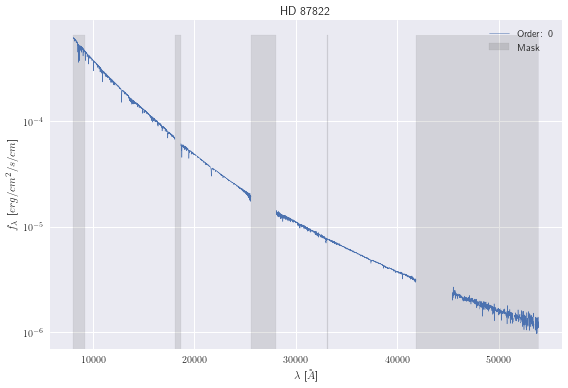

In [99]:
data.plot();

## Setting up the model

Now we can set up our initial model. We need, at minimum, an emulator, our data, and a set of the library grid parameters. Every extra keyword argument we add is added to our list of parameters. For more information on what parameters are available and what effect they have, see the [SpectrumModel documentation](../api/models.rst#SpectrumModel). 

Some of these parameters are based on guesses or pre-existing knowledge. In particular, it's important to tune `log_scale` to a reasonable value, so take some iterations of plotting against the data to get a good starting point. We also want our `global_cov:log_amp` to be reasonable, so pay attention to the $\sigma$-contours in the residuals plots, too.

Starting with the [Simbad entry for our star](http://simbad.u-strasbg.fr/simbad/sim-basic?Ident=HD+87822+%09&submit=SIMBAD+search) we track down some good initial values. In particular, [this paper](https://ui.adsabs.harvard.edu/abs/2011A%26A...531A.165P/abstract) has reasonable values, plus we can use information from the FITS header (provided by [Rayner, J.T., Cushing, M.C., & Vacca (2009)](https://ui.adsabs.harvard.edu/abs/2009ApJS..185..289R/abstract))

In [100]:
from Starfish.models import SpectrumModel

model = SpectrumModel(
    "F_SPEX_emu.hdf5",
    data,
    grid_params=[6573, 4.06, 0.10],
    log_scale=-3.84,
    Av=Av,
    global_cov=dict(log_amp=25, log_ls=10),
)
model

SpectrumModel
-------------
Data: HD 87822
Emulator: F_SPEX_emu
Log Likelihood: None

Parameters
  Av: 0.07750000000000001
  T: 6573
  Z: 0.1
  global_cov:
    log_amp: 25
    log_ls: 10
  log_scale: -3.84
  logg: 4.06

In this plot, we can see the data and model in the left pane, the absolute errors (residuals) along with the diagonal of the covariance matrix as $\sigma$ contours in the top-right, and the relative errors (residuals / flux) in the bottom-right

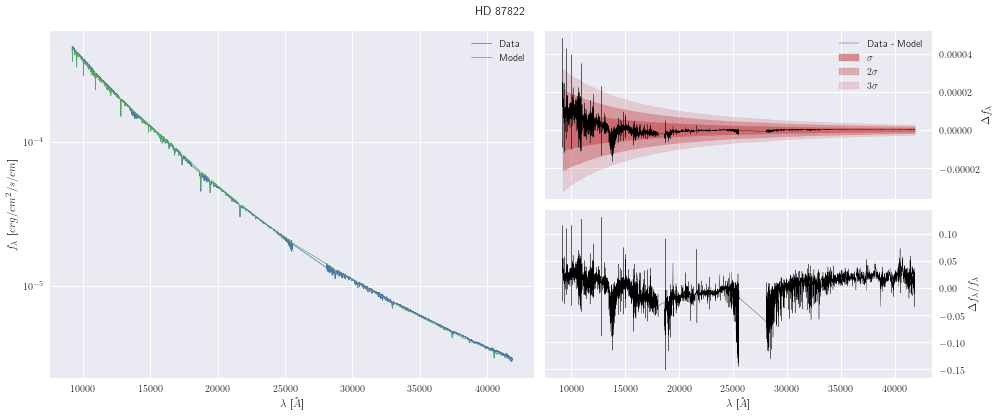

In [102]:
model.plot();

## Numerical Optimization

Now lets do a *maximum a posteriori* (MAP) point estimate for our data. 


TODO<Here we freeze `vz` because we do not wish to fit it, but we want to  Note that we freeze `logg` here because the PHOENIX models' response to `logg` compared to our data are relatively flat, so we fix the value using the [freeze](../api/models.rst#parametrization) mechanics.>

In [103]:
# These are the fittable parameters
model.labels

('Av',
 'T',
 'Z',
 'global_cov:log_amp',
 'global_cov:log_ls',
 'log_scale',
 'logg')

In [104]:
import scipy.stats as st

priors = {
    "T": st.uniform(6200, 800),
    "logg": st.uniform(4.0, 0.3),
    "Z": st.uniform(0, 0.3),
    "log_scale": st.norm(-3.84, 0.5),
    "Av": st.uniform(0, 2),
}

In [105]:
%timeit model.log_likelihood(priors)

4.68 s ± 149 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%time model.train(priors)

In [ ]:
model

In [ ]:
model.plot();